Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos <br>
Primer Semestre 2024
<br>

<h1><center>Tarea 4: Modelos para imágenes y texto </center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 09 de junio de 2024

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas.
- El notebook debe tener todas las celdas de código ejecutadas.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [1]:
#Cargue las liberías que va a utilizar
import nltk
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from keras.models import Sequential
from nltk.tokenize import word_tokenize
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Sección 1: Clasificación de imágenes (30 puntos)

Para esta primera sección se utilizará el dataset de imágenes **MNIST**. Este conjunto de datos incluye números escritos manualmente, entre 0 y 9.

Cada imágen tiene una dimensión de 28x28 y está en blanco y negro. Es decir, una imagen se ve representada como un arreglo de dimensión (28, 28).

Más información: http://yann.lecun.com/exdb/mnist/

## Parte 1: Carga de datos y procesamiento (5 puntos)

### 1.1 Importe el dataset y analicelo (4 puntos)  

* Indique el número de imágenes que posee el conjunto de datos. ¿Las clases están balanceadas?
* Muestre dos imágenes de cada clase.


In [2]:
#Entregar esta celda
#Cargar dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#Normalización
x_train = x_train / 255
x_test = x_test / 255

RESPUESTA:

In [3]:
num_train_images = x_train.shape[0]
num_test_images = x_test.shape[0]
total_images = num_train_images + num_test_images

print(f'Número de imágenes en el conjunto de entrenamiento: {num_train_images}')
print(f'Número de imágenes en el conjunto de prueba: {num_test_images}')
print(f'Número total de imágenes: {total_images}')

Número de imágenes en el conjunto de entrenamiento: 60000
Número de imágenes en el conjunto de prueba: 10000
Número total de imágenes: 70000


In [4]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique, counts))

unique, counts = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique, counts))

cantidad_clases = {}

for k, v in class_distribution_train.items():
    cantidad_clases[k] = v

for k, v in class_distribution_test.items():
    cantidad_clases[k] += v

suma_total = sum(cantidad_clases.values())

for k, v in cantidad_clases.items():
    print(f'Clase {k}: {v} imágenes')
    print(f'Porcentaje de imágenes: {v / suma_total * 100:.2f}%')

Clase 0: 6903 imágenes
Porcentaje de imágenes: 9.86%
Clase 1: 7877 imágenes
Porcentaje de imágenes: 11.25%
Clase 2: 6990 imágenes
Porcentaje de imágenes: 9.99%
Clase 3: 7141 imágenes
Porcentaje de imágenes: 10.20%
Clase 4: 6824 imágenes
Porcentaje de imágenes: 9.75%
Clase 5: 6313 imágenes
Porcentaje de imágenes: 9.02%
Clase 6: 6876 imágenes
Porcentaje de imágenes: 9.82%
Clase 7: 7293 imágenes
Porcentaje de imágenes: 10.42%
Clase 8: 6825 imágenes
Porcentaje de imágenes: 9.75%
Clase 9: 6958 imágenes
Porcentaje de imágenes: 9.94%


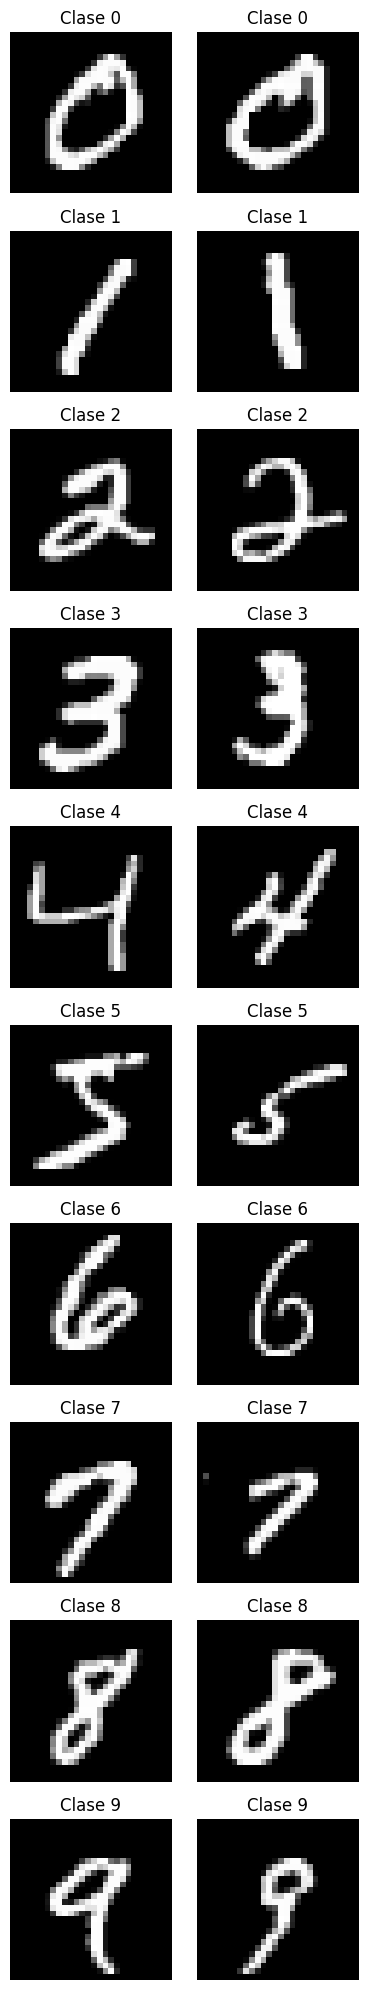

In [5]:
fig, axes = plt.subplots(10, 2, figsize=(4, 20))
for i in range(10):
    class_indices = np.where(y_train == i)[0]
    axes[i, 0].imshow(x_train[class_indices[0]], cmap='gray')
    axes[i, 0].set_title(f'Clase {i}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(x_train[class_indices[1]], cmap='gray')
    axes[i, 1].set_title(f'Clase {i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

### 1.2 Creación de validación (1 punto)

Utilizando el conjunto train, construya un conjunto de validación (10%).


RESPUESTA:

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

## Parte 2: Crear clasificadores utilizando Convolutional Neural Network (CNN) (25 puntos)

### 2.1 Crear clasificador CNN (10 puntos)

* Entrene un clasificador multiclase para discriminar entre los diez dígitos del dataset. Considere 3 épocas y batch_size=64.

* Grafique las curvas de accuracy para los conjuntos train y validation.
Comente.
* Grafique las funciones de pérdida para los conjuntos train y validation. Comente.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Comente.

**Observaciones**

* Considere que el número de parámetros de la red puede hacer más lento el proceso de entrenamiento.

* Si utiliza CPU podría demorar entre 4 y 7 minutos por época. En este caso, no tiene límite de tiempo de uso.

* Si utiliza GPU puede acelerar el proceso de entrenamiento significativamente (menos de 1 minuto en total). Google Colab entrega este tipo de recursos de manera gratuita. Para activar la GPU debe ir a la sección **Entorno de ejecución** --> **Cambiar tipo de entorno de ejecución** y seleccionar la opción **T4 GPU**. Considere que el tiempo de uso es limitado.


RESPUESTA:

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

c:\Users\franc\OneDrive - Universidad Católica de Chile\UC\7° Semestre\Mineria de datos\IIC2433\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=64,
    epochs=3,
    validation_data=(x_val, y_val),
    verbose=2
)

Epoch 1/3
844/844 - 24s - 28ms/step - accuracy: 0.9359 - loss: 0.2042 - val_accuracy: 0.9883 - val_loss: 0.0406
Epoch 2/3
844/844 - 23s - 27ms/step - accuracy: 0.9795 - loss: 0.0695 - val_accuracy: 0.9902 - val_loss: 0.0329
Epoch 3/3
844/844 - 40s - 47ms/step - accuracy: 0.9840 - loss: 0.0523 - val_accuracy: 0.9900 - val_loss: 0.0334


In [10]:
loss, accuracy = model.evaluate(x_train, y_train)
print("Final training loss: {:.8f}".format(loss))
print("Final training accuracy: {:.4%}".format(accuracy))

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9930 - loss: 0.0231
Final training loss: 0.02269038
Final training accuracy: 99.3074%


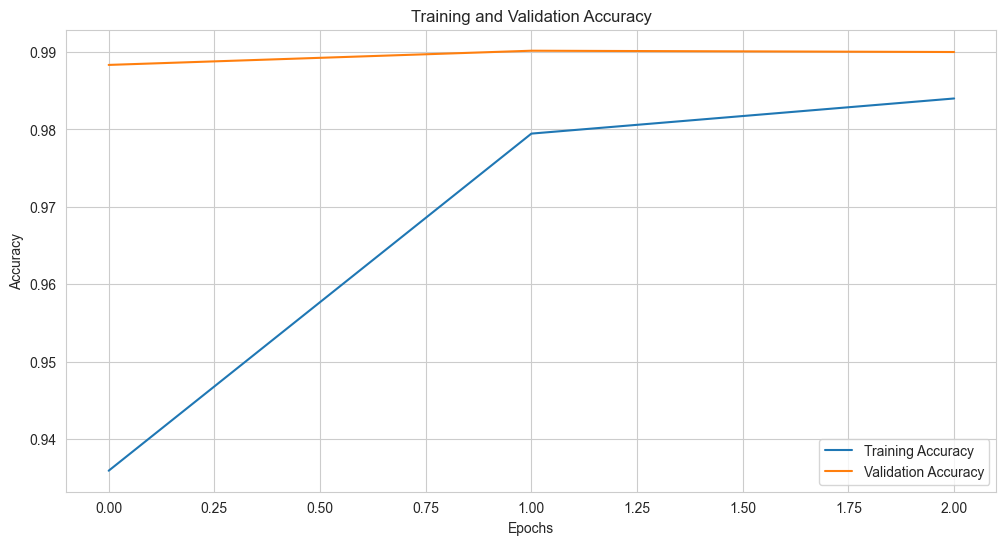

In [11]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

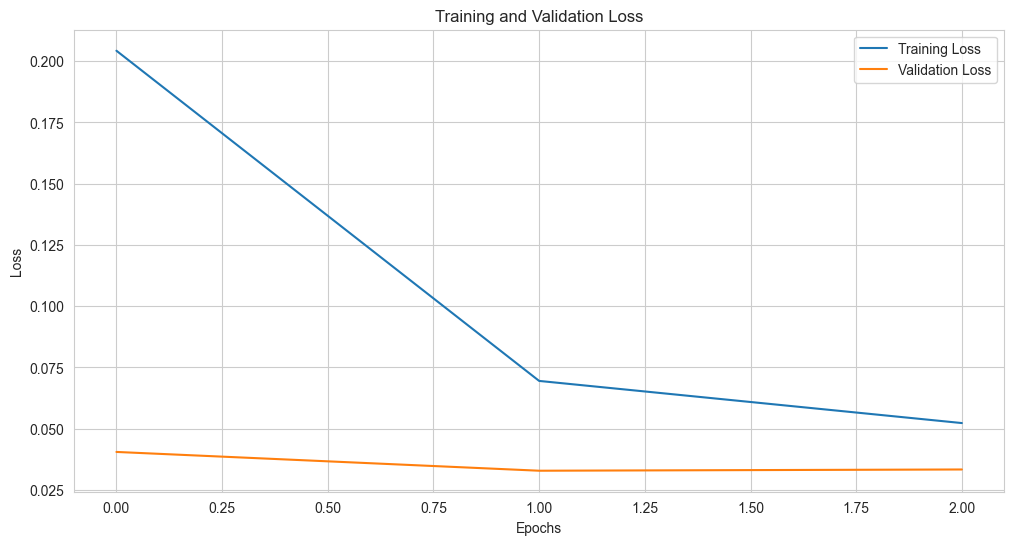

In [12]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
y_pred = model.predict(x_test).argmax(axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### 2.2 Descripción Variational Autoencoder (VAE) (3 puntos)

Explique la función que cumple el **Encoder** y **Decoder** en la arquitectura VAE.

RESPUESTA:

### 2.3 Creación datos sintéticos con VAE (8 puntos)

Utilizando la arquitectura Variational Autoencoder cree 20 ejemplos sintéticos. Muestre las imágenes generadas y comente su calidad.

Utilice 10 épocas y un batch_size igual a 64.

**Observación**

Si utiliza CPU podría demorar entre 1 y 3 minutos por época. En caso de usar GPU, toma menos de 1 minuto en total.

RESPUESTA:

### 2.4 Evaluar datos sintéticos con clasificador (4 puntos)

Considerando los 20 ejemplos creados en 2.3, aplique el clasificador entrenado en 2.1 para identificar las clases. Comente los resultados.

Si existiera un desbalance en las clases que influye negativamente en las métricas de evaluación, ¿se podrían utilizar estos ejemplos para hacer aumento de datos? Justifique su respuesta en función de los resultados obtenidos al aplicar el clasificador.

RESPUESTA:

# Sección 2: Clasificación de texto (30 puntos)

El conjunto de datos corresponde a diferentes posts realizados en la plataforma X (aka Twitter) y la respectiva clasificación de la emoción asociada a ese post. Las emociones pueden ser: `sadness/tristeza` (0), `joy/alegria` (1), `love/amor` (2), `anger/enojo` (3), `fear/miedo` (4) y `surprise/sorpresa` (5). La tarea que tendran que realizar es codificar los textos de una manera valida, para luego, poder entrenar un modelo de MLP (y posteriormente, un modelo SVM) para clasificar los textos en las emociones correspondientes, evaluar los rendimientos de los modelos y dar hipotesis sobre por qué creen que un modelo es mejor que otro.

El dataset incluye dos columnas:

* Text: Mensaje de X.
* label: Etiqueta con el sentimiento asignado.

Más información en: `https://www.kaggle.com/datasets/nelgiriyewithana/emotions`

## Parte 1: Carga de Datos (4 Puntos)

### 1.1 Importe el dataset y analicelo (4 puntos)

* Indique el número de elementos por clase.

* Construya un nuevo dataset asegurando que cada clase tenga el mismo tamaño que la clase minoritaria. Para ello utilice un muestreo aleatorio simple sobre las clases que poseen mayor cantidad de ejemplos. ¿Qué ventajas y desventajas tiene este enfoque?

**Observación:**

Debe seguir trabajando con el dataset balanceado.

RESPUESTA:

In [15]:
text = pd.read_csv('text.csv')
text = text.drop(columns=['Unnamed: 0'])
text.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [16]:
text.shape

(416809, 2)

In [17]:
text.isna().sum()

text     0
label    0
dtype: int64

In [18]:
uniques, counts = np.unique(text['label'], return_counts=True)
class_distribution = dict(zip(uniques, counts))

cantidad_clases = {}

for k, v in class_distribution.items():
    cantidad_clases[k] = v

suma_total = sum(cantidad_clases.values())

for k, v in cantidad_clases.items():
    print(f'Clase {k}: {v} textos')
    print(f'Porcentaje de textos: {v / suma_total * 100:.2f}%')

Clase 0: 121187 textos
Porcentaje de textos: 29.07%
Clase 1: 141067 textos
Porcentaje de textos: 33.84%
Clase 2: 34554 textos
Porcentaje de textos: 8.29%
Clase 3: 57317 textos
Porcentaje de textos: 13.75%
Clase 4: 47712 textos
Porcentaje de textos: 11.45%
Clase 5: 14972 textos
Porcentaje de textos: 3.59%


In [19]:
min_class = min(class_distribution.values())
min_class

14972

In [20]:
balanced_text = pd.DataFrame()

for label in class_distribution.keys():
    class_subset = text[text['label'] == label]
    balanced_class_subset = class_subset.sample(n=min_class, random_state=42)
    balanced_text = pd.concat([balanced_text, balanced_class_subset], axis=0)

balanced_text['label'].value_counts()

label
0    14972
1    14972
2    14972
3    14972
4    14972
5    14972
Name: count, dtype: int64

## Parte 2: Preprocesamiento (6 Puntos)
Remoción de stopwords, codificación mediante count vectorizer y TF-IDF y generación de conjuntos train y test.

Es importante notar que algunas características del texto, como la longitud de sentencias y frecuencia de palabras, dificultan el proceso de entrenamiento de un modelo de clasificación. Por lo mismo, es necesario realizar un preprocesamiento que permita codificar el texto para entrenar modelos. Para esto, se busca que utilicen diferentes tipos de codificación como `TF-IDF` y `Bag-of-Words(BOW)`. Ambos métodos, ya implementados en sklearn, se encargan de construir una representación vectorial para cada sentencia dentro de un corpus (columna con mensajes).

Posteriormente, para cada una de estas codificaciones, deberá entrenar modelos basados en MLP y SVM para clasificar los textos en las emociones correspondientes y evaluar sus rendimientos.

**Observaciones**

* A continuación, se dejan los enlaces de sklearn para trabajar con los métodos TF-IDF y BOW:
1. TF-IDF:  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
2. BOW: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

* Para ambas codificaciones, se recomienda utilizar un máximo de 5,000 features (para reducir tiempo de entrenamiento) y remover las stopwords del idioma correspondiente al utilizado en el dataset. `Hint: esto se puede realizar mediante los parametros de las funciones presentadas anteriormente`.

### 2.1 Bag of Words (BOW) (2 puntos)

Utilizando Bag-of-Words, obtenga las representaciones vectoriales de los mensajes de la columna `text`.

RESPUESTA:

In [21]:
count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X_bow = count_vectorizer.fit_transform(balanced_text['text'])

### 2.2 TF-IDF (2 puntos)

Utilizando TF-IDF, obtenga las representaciones vectoriales de los mensajes de la columna `text`.

RESPUESTA:

In [22]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_tfidf = tfidf_vectorizer.fit_transform(balanced_text['text'])

### 2.3 División de datos para cada encoding (2 puntos)

Divida los datos de cada una de vectorizaciones en `train` y `test`, con un tamaño de `85%` y `15%`, respectivamente. Para esto, debera utilizar la funcion `train_test_split` de `sklearn` con un `random_state=42` (recuerde mantener una proporcion balanceada de las clases).

**Observación**

Para mantener el balance de clases al aplicar `train_test_split` puede utilizar el parámetro `stratify`.

RESPUESTA:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, balanced_text['label'], test_size=0.15, random_state=42, stratify=balanced_text['label'])

## Parte 3: Entrenamiento clasificador MLP (8 puntos)

En esta parte, se busca que usted entrene un modelo de MLP para clasificar los textos en las emociones correspondientes.

**Observación**

Se recomienda trabajar con **MLPClassifier**.

Más información en https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

### 3.1 MLP + BOW (3 puntos)

* Entrene un clasificador MLP utilizando la representación de texto obtenida con Bag-of-Words. Considere 3 capas ocultas de 30 a 50 neuronas cada una, con activación `relu` y 50 iteraciones.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Comente.

* Grafique la matríz de confusión. Comente.

**Observación**

El proceso de entrenamiento puede tardar entre 1 y 3 minutos, dependiendo del número de neuronas definidas.

RESPUESTA:

### 3.2 MLP + TF-IDF (3 puntos)

* Entrene un clasificador MLP utilizando la representación de texto obtenida con TF-IDF. Considere 3 capas ocultas de 30-50 neuronas cada una, con activación `relu` y 50 iteraciones.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Comente.

* Grafique la matríz de confusión. Comente.

RESPUESTA:

### 3.3 Analisis de resultados - Comparación de encoders (2 puntos)

En este caso, si un modelo con cierto encoding funciono mejor que otro, ¿Por qué creen que fue asi? ¿Que ventajas/desventajas tiene cada uno de los encodings?

RESPUESTA:

## Parte 4: Entrenamiento clasificador SVM (9 puntos)

### 4.1 Entrenamiento modelo SVM (7 puntos)

* **Considerando la vectorizacion que le haya dado mejores resultados en la Parte 3**, entrene un modelo SVM para clasificar los textos en las emociones correspondientes. Para esto, considere los kernels `linear`, `poly` y `rbf`.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Compare los resultados obtenidos al trabajar con los 3 kernels.

**Observación**

El proceso de entrenamiento al trabajar con los kernels `poly` y `rbf` puede tardar entre 5 y 10 minutos.

RESPUESTA:

### 4.2 Analisis de resultados - Comparación de kernels (2 puntos).

¿Cómo funcionaron los kernels? ¿Por qué cree que fue asi?

RESPUESTA:

## Parte 5: Comparar resultados de MLP y SVM (3 puntos).

¿Qué modelo entregó mejores resultados? ¿Por qué cree que fue asi?

RESPUESTA: